In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name

bucket = sagemaker_session.default_bucket()

role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


(512, 512, 3)
(512, 512, 3)
[0. 1.]
(array([0., 1.], dtype=float32), array([754935,  31497]))


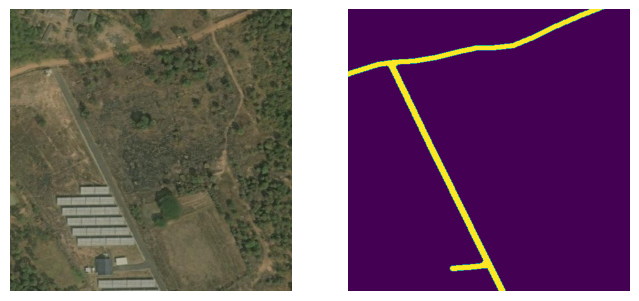

In [3]:
import torch
import boto3
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import io
from PIL import Image
import numpy as np

s3 = boto3.client("s3")
image_list = s3.list_objects(Bucket=bucket, Prefix="sagemaker/seg-data/train/images").get("Contents")
mask_list = s3.list_objects(Bucket=bucket, Prefix="sagemaker/seg-data/train/masks").get("Contents")

image = "10246_1_1.jpg"
mask = "10246_1_1.png"

s3.download_file(bucket, "sagemaker/seg-data/train/images/" + image, image)
s3.download_file(bucket, "sagemaker/seg-data/train/masks/" + mask, mask)


img=mpimg.imread(image, "jpeg")
msk=mpimg.imread(mask, "jpeg")

print(img.shape)
print(msk.shape)
print(np.unique(msk[:,:, 2]))
#map1=msk[:,:, 2] == msk[:,:, 1]
print(np.unique(msk, return_counts=True))
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 1
figure.add_subplot(rows, cols, 1)
plt.axis("off")
plt.imshow(img)
figure.add_subplot(rows, cols, 2)
plt.axis("off")
plt.imshow(msk[:,:, 1])
plt.show()

In [4]:
inputs = "s3://sagemaker-us-west-2-071681976313/sagemaker/seg-data/"

In [5]:
!pygmentize deeplab.py

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="deeplab.py",
    role=role,
    py_version="py38",
    framework_version="1.11.0",
    instance_count=1,
    instance_type="ml.p4de.24xlarge",
    hyperparameters={"epochs": 1, "batch-size": 128, "lr": 0.00003},
)

import argparse
import json
import logging
import os
import sys

#import sagemaker_containers
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from sklearn.metrics import f1_score, roc_auc_score


logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #self.deeplab = deeplabv3_resnet50(weights=None,num_classes=1)
        self.deeplab = deeplabv3_resnet101(pretrained=True, 

In [6]:
estimator.fit({"training": inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-07-15-13-01-20-320


2024-07-15 13:01:20 Starting - Starting the training job...
2024-07-15 13:01:30 Pending - Training job waiting for capacity...
2024-07-15 13:01:57 Pending - Preparing the instances for training...........................
2024-07-15 13:06:24 Downloading - Downloading input data......
2024-07-15 13:07:35 Downloading - Downloading the training image..................
2024-07-15 13:10:52 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-07-15 09:11:21,354 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-07-15 09:11:21,452 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-07-15 09:11:21,462 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-07-15 09:11:21,464 sagemaker_pytorch_container.training INFO     Invoking user train

In [18]:
print(estimator.model_data)
prefix = estimator.model_data.split(bucket + "/")[1]
filename = estimator.model_data.split("/")[-1]
#s3.download_file(bucket, prefix, filename)

import tarfile

if filename.endswith("tar.gz"):
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()

s3://sagemaker-us-west-2-071681976313/pytorch-training-2024-07-15-13-01-20-320/output/model.tar.gz


(512, 512, 3)
torch.Size([3, 512, 512])
(512, 512, 3)
(array([  0., 255.]), array([754935,  31497]))


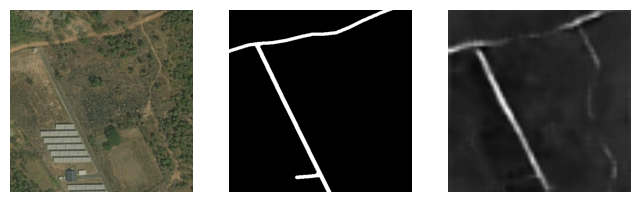

In [19]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.deeplab = deeplabv3_resnet101(pretrained=True, progress=True)
        self.deeplab.classifier[4] = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, stride=1)

    def forward(self, x):
        return self.deeplab(x)

# Specify a path
PATH = "./model.pth"

# Load
model = Net()

# original saved file with DataParallel
state_dict = torch.load(PATH)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)
#model.load_state_dict(torch.load(PATH))
model.eval()

image = Image.open("./10246_1_1.jpg")
image.convert("RGB")
image = np.asarray(image) / 255
#image = np.rollaxis(image, 3, 1)
image.astype(dtype="float32")
print(image.shape)
print(torch.tensor(image).permute(2,0,1).shape)

mask = Image.open("./10246_1_1.png")
#mask.convert("RGB")
mask = np.asarray(mask) * 1.0
#image = np.rollaxis(image, 3, 1)
mask.astype(dtype="float32")
print(mask.shape)
print(np.unique(mask, return_counts=True))


output = model(torch.tensor(image).permute(2,0,1).float().unsqueeze(0))


figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 1
figure.add_subplot(rows, cols, 1)
plt.axis("off")
plt.imshow(image)
figure.add_subplot(rows, cols, 2)
plt.axis("off")
plt.imshow(mask)
figure.add_subplot(rows, cols, 3)
plt.axis("off")
plt.imshow(output['out'].data.cpu().numpy()[0, 0], cmap="gray")
plt.show()